In [ ]:
    from google.colab import drive

    drive.mount("/content/drive")
    


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import argparse
import sys
import numpy as np
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
from keras import layers, optimizers, losses, metrics , callbacks , models , Sequential
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from PIL import Image
from sklearn.metrics import precision_score,recall_score,f1_score

In [ ]:

def parse_file(FileSetName):
  images = []
  with open(FileSetName, "rb") as f:
    magic_number = int.from_bytes(f.read(4),byteorder='big')
    number_images = int.from_bytes(f.read(4),byteorder='big')
    number_of_rows = int.from_bytes(f.read(4),byteorder='big')
    number_of_columns = int.from_bytes(f.read(4),byteorder='big')
    for x in range(0,number_images):
      npBytes = np.fromfile(f, dtype='B',count=number_of_columns * number_of_rows, sep='', offset=0)
      # print(npBytes)
      newarr = npBytes.reshape(28,28)
      #img = Image.fromarray(newarr, 'L')
      #img.save('image'+str(x)+'.png')
      #plt.show()
      images.append(newarr)
    npimages = np.asarray(images)
    return (npimages,magic_number,number_images,number_of_rows,number_of_columns)

In [ ]:
def read_labels_file(filename):
  with open(filename, "rb") as f:
    magic_number = int.from_bytes(f.read(4),byteorder='big')
    number_items = int.from_bytes(f.read(4),byteorder='big')
    npBytes = np.fromfile(f, dtype='B',count=number_items, sep='', offset=0)
    print(npBytes)
    return (npBytes)

In [ ]:
# parser = argparse.ArgumentParser()
# parser.add_argument("-d", "--Dataset", help="Insert dataset file",required="yes")
# args = parser.parse_args()
# FileDataSet = args.Dataset
# print( "Dataset {}".format(FileDataSet))

In [ ]:
##HYPERPARAMETERS##
learn_rate = 0.0001
batchSize = 128
Epochs_Num = 100
Block_Num = 2 #we define a block as a combination of Convolution,Batch Normalization and pooling - Restriction, max = 3
Convolutions_per_Block = (2,2,3) #we may make more convolutions than one per block / we include last block that may not enclude pooling
FilterSize =  ( ((3,3),(3,3)),((3,3),(3,3)),((3,3),(3,3),(3,3)) ) #filter size for each Convolution
FiltersNum = ( (32,32),(64,64),(128,128,256)) #number of filters per Convolution


In [ ]:
def Convpool(convolutionx,numfilters,convsize,convNums):
  convolutionret = convolutionx
  for i in range(0,convNums):
    convolutionret = layers.Conv2D(numfilters[i],convsize[i],activation='relu',strides=1,padding='same')(convolutionret)
    convolutionret = layers.BatchNormalization()(convolutionret)
  poolingret = layers.MaxPooling2D(pool_size=(2,2))(convolutionret)
  return poolingret

In [ ]:
def Convup(convolutionx,numfilters,convsize,convNums):
  convolutionret = convolutionx
  for i in range(convNums-1,-1,-1):
    convolutionret = layers.Conv2D(numfilters[i],convsize[i],activation='relu',strides=1,padding='same')(convolutionret)
    convolutionret = layers.BatchNormalization()(convolutionret)
  upsamplingret = layers.UpSampling2D((2,2))(convolutionret)
  return upsamplingret

In [ ]:
def encoder(imageinput,BlocksNum,FiltersNum,FilterSize,Convolutions_per_Block):
  blockreturn = imageinput
  for i in range(0,BlocksNum):
    blockreturn = Convpool(blockreturn,FiltersNum[i],FilterSize[i],Convolutions_per_Block[i])
  for i in range(0,Convolutions_per_Block[-1]):
    blockreturn = layers.Conv2D(FiltersNum[-1][i],FilterSize[-1][i],activation='relu',padding = 'same')(blockreturn)
    blockreturn = layers.BatchNormalization()(blockreturn)
  return blockreturn

In [ ]:
def decoder(convolution3,BlocksNum,FiltersNum,FilterSize,Convolutions_per_Block):
  blockreturn = convolution3
  for i in range(Convolutions_per_Block[-1]-1,-1,-1):
    blockreturn = layers.Conv2D(FiltersNum[-1][i],FilterSize[-1][i],activation='relu',padding = 'same')(blockreturn)
    blockreturn = layers.BatchNormalization()(blockreturn)
  for i in range(BlocksNum-1,-1,-1):
    blockreturn = Convup(blockreturn,FiltersNum[i],FilterSize[i],Convolutions_per_Block[i])
  decoded = layers.Conv2D(1,FilterSize[0][0],activation='sigmoid',padding='same')(blockreturn) #28 x 28 x 1
  return decoded

In [ ]:
with tf.device("gpu:0"):
  FileDataSet = "/content/drive/My Drive/train-images-idx3-ubyte"
  array_images,mNumber,nImages,nRows,nCols = parse_file(FileDataSet)
  print(array_images.shape)
  identities = np.arange(nImages)
  # print(array_images)
  X_train, X_test, y_train, y_test = train_test_split(array_images,identities, test_size=0.3,shuffle=True,random_state=11)
  X_train = X_train / 255
  X_test = X_test / 255
  print(X_test.shape)
  print(X_train.shape)

(60000, 28, 28)
(18000, 28, 28)
(42000, 28, 28)


In [ ]:
  ##build NN##
  input_img = keras.Input(shape=(28,28,1))
  
  convolution3 = encoder(input_img,Block_Num,FiltersNum,FilterSize,Convolutions_per_Block)
  decoded = decoder(convolution3,Block_Num,FiltersNum,FilterSize,Convolutions_per_Block)
  autoencoder = keras.Model(input_img, decoded)
  opt= keras.optimizers.Adam(learning_rate=learn_rate)
  autoencoder.compile(optimizer=opt,loss='mean_squared_error')
  callbackmod=[
  keras.callbacks.EarlyStopping(patience=5),
  callbacks.ModelCheckpoint(filepath='model.h5',save_best_only=True,monitor='val_loss',mode='min',),
  keras.callbacks.TensorBoard(log_dir="logs",
  histogram_freq=1,
  write_graph=True,
  write_images=True,
  update_freq="epoch",
  profile_batch=2,
  embeddings_freq=0,
  embeddings_metadata=None)
  ]
  history1 = autoencoder.fit(X_train,X_train,
                epochs=Epochs_Num,
                batch_size=batchSize,
                validation_data=(X_test, X_test),callbacks=[callbackmod])


Epoch 1/100
329/329 [==============================] - 30s 92ms/step - loss: 0.0654 - val_loss: 0.0876
Epoch 2/100
329/329 [==============================] - 30s 91ms/step - loss: 0.0211 - val_loss: 0.0149
Epoch 3/100
329/329 [==============================] - 30s 91ms/step - loss: 0.0123 - val_loss: 0.0100
Epoch 4/100
329/329 [==============================] - 30s 91ms/step - loss: 0.0086 - val_loss: 0.0078
Epoch 5/100
329/329 [==============================] - 30s 91ms/step - loss: 0.0068 - val_loss: 0.0063
Epoch 6/100
329/329 [==============================] - 30s 91ms/step - loss: 0.0057 - val_loss: 0.0054
Epoch 7/100
329/329 [==============================] - 30s 91ms/step - loss: 0.0049 - val_loss: 0.0046
Epoch 8/100
329/329 [==============================] - 30s 92ms/step - loss: 0.0043 - val_loss: 0.0045
Epoch 9/100
329/329 [==============================] - 30s 91ms/step - loss: 0.0039 - val_loss: 0.0037
Epoch 10/100
329/329 [==============================] - 30s 90ms/step - l

In [ ]:
!pwd
!ls
!mv "/content/logs" "/content/drive/My Drive/"
!cp "/content/model.h5" "/content/drive/My Drive/"
!ls

/content
drive  logs  model.h5  sample_data
drive  model.h5  sample_data


In [ ]:
autoencoder.summary() 


Model: "functional_63"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_22 (InputLayer)        [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_299 (Conv2D)          (None, 28, 28, 32)        320       
_________________________________________________________________
batch_normalization_267 (Bat (None, 28, 28, 32)        128       
_________________________________________________________________
conv2d_300 (Conv2D)          (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization_268 (Bat (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_40 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_301 (Conv2D)          (None, 14, 14, 64)      

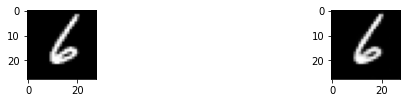

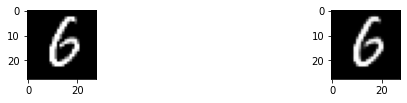

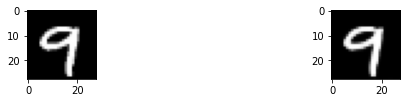

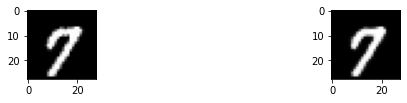

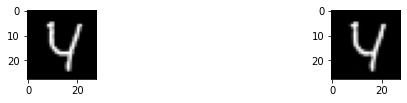

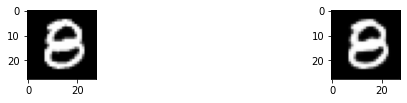

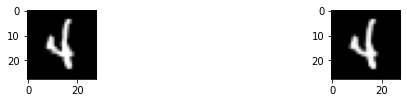

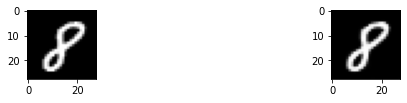

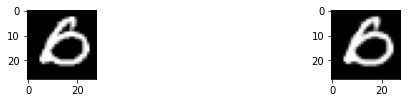

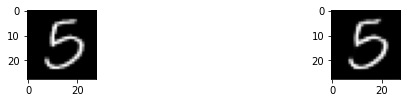

In [ ]:
  decoded_imgs = autoencoder.predict(X_test)
  decoded_images_orig = np.reshape(decoded_imgs, newshape=(decoded_imgs.shape[0], 28, 28))

  num_images_to_show = 10
for im_ind in range(num_images_to_show):
    
    plot_ind = im_ind*2 + 1
    
    rand_ind = np.random.randint(low=0, high=X_test.shape[0])
    # rand_ind = np.random.randint(low=0, high=X_test.shape[0])
    
    plt.figure(figsize=((10,15)))
    
    _ = plt.subplot(num_images_to_show, 2, plot_ind)
    _ = plt.imshow(X_test[rand_ind, :, :], cmap="gray")
    
    _ = plt.subplot(num_images_to_show, 2, plot_ind+1)
    _ = plt.imshow(decoded_images_orig[rand_ind, :, :], cmap="gray")

    _ = plt.show();
    

0.0010082173394039273


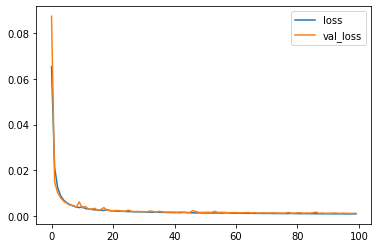

In [ ]:
loss = history1.history['loss']
val_loss = history1.history['val_loss']
print(min(val_loss))
plt.plot(loss)  
plt.plot(val_loss)
plt.legend(['loss', 'val_loss'])
plt.show()


In [ ]:
!rm "/content/drive/My Drive/model.h5"
!rm -R "/content/drive/My Drive/logs"
!rm -R logs*
!rm  model*
!ls 

drive  sample_data


In [ ]:

saved_model = models.load_model("/content/drive/My Drive/model_best.h5")
dense_num = 128
lrate = 0.001
lrate_2 = 0.0001
batch_sz = 128


In [ ]:
train_data,mnum,nimg,nrow,ncol = parse_file("/content/drive/My Drive/train-images-idx3-ubyte")
train_labels = read_labels_file("/content/drive/My Drive/train-labels-idx1-ubyte")
test_labels = read_labels_file("/content/drive/My Drive/t10k-labels-idx1-ubyte")
test_data,magicNum,numbImages,numbRows,numbCols = parse_file("/content/drive/My Drive/t10k-images-idx3-ubyte")
onehot_train_labels = np.zeros((train_labels.size,train_labels.max()+1))
onehot_train_labels[np.arange(train_labels.size),train_labels] = 1
onehot_test_labels = np.zeros((test_labels.size, test_labels.max()+1))
onehot_test_labels[np.arange(test_labels.size),test_labels] = 1

test_data = test_data / 255
train_data = train_data / 255

[5 0 4 ... 5 6 8]
[7 2 1 ... 4 5 6]


In [ ]:
classification_model = Sequential()
length = len(saved_model.layers)
flatten = layers.Flatten()(saved_model.layers[length//2+1].output)
x = layers.Dense(dense_num,activation="relu")(flatten)
out = layers.Dense(10,activation="softmax")(x)
classification_model = keras.Model(saved_model.input,out)
classification_model.summary()
# saved_model.summary()

Model: "functional_73"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_22 (InputLayer)        [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_299 (Conv2D)          (None, 28, 28, 32)        320       
_________________________________________________________________
batch_normalization_267 (Bat (None, 28, 28, 32)        128       
_________________________________________________________________
conv2d_300 (Conv2D)          (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization_268 (Bat (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_40 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_301 (Conv2D)          (None, 14, 14, 64)      

In [ ]:
opt= keras.optimizers.Adam(learning_rate=lrate)
classification_model.compile(optimizer=opt,loss='categorical_crossentropy',metrics=[tf.keras.metrics.CategoricalAccuracy(),tf.keras.metrics.Recall(),tf.keras.metrics.Precision()])
for layer_freeze in classification_model.layers[:-3]:
  layer_freeze.trainable = False
callbackmod2=[
  keras.callbacks.EarlyStopping(patience=4),
  callbacks.ModelCheckpoint(filepath='model2_classification.h5',save_best_only=True,monitor='val_loss',mode='min',),
  keras.callbacks.TensorBoard(log_dir="logs2",
  histogram_freq=1,
  write_graph=True,
  write_images=True,
  update_freq="epoch",
  profile_batch=2,
  embeddings_freq=0,
  embeddings_metadata=None)
  ]
history2 = classification_model.fit(train_data,onehot_train_labels,
                epochs=Epochs_Num,
                batch_size=batch_sz,
                validation_data=(test_data,onehot_test_labels),callbacks=[callbackmod2])


# saved_model_weights = saved_model.get_weights()
# saved_model_weights = np.asarray(saved_model_weights)
# newweights = model2.get_weights()
# newweights = np.asarray(newweights)
# print(newweights.shape)
# print(saved_model_weights.shape)
# length2 = len(saved_model_weights)
# new  = saved_model_weights[:length2//2-1]-newweights[:-2]
# print(new)


Epoch 1/100
469/469 [==============================] - 29s 62ms/step - loss: 0.1355 - categorical_accuracy: 0.9653 - recall_6: 0.9632 - precision_11: 0.9698 - val_loss: 0.0786 - val_categorical_accuracy: 0.9799 - val_recall_6: 0.9793 - val_precision_11: 0.9813
Epoch 2/100
469/469 [==============================] - 29s 61ms/step - loss: 0.0441 - categorical_accuracy: 0.9873 - recall_6: 0.9867 - precision_11: 0.9882 - val_loss: 0.0413 - val_categorical_accuracy: 0.9887 - val_recall_6: 0.9884 - val_precision_11: 0.9894
Epoch 3/100
469/469 [==============================] - 28s 61ms/step - loss: 0.0286 - categorical_accuracy: 0.9918 - recall_6: 0.9913 - precision_11: 0.9923 - val_loss: 0.0484 - val_categorical_accuracy: 0.9879 - val_recall_6: 0.9873 - val_precision_11: 0.9887
Epoch 4/100
469/469 [==============================] - 29s 61ms/step - loss: 0.0290 - categorical_accuracy: 0.9915 - recall_6: 0.9911 - precision_11: 0.9919 - val_loss: 0.0405 - val_categorical_accuracy: 0.9902 - val_

Prediction number: 3 ,right class 3


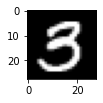

Prediction number: 0 ,right class 0


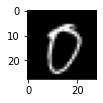

Prediction number: 6 ,right class 6


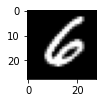

Prediction number: 3 ,right class 3


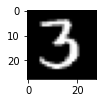

Prediction number: 5 ,right class 5


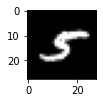

Prediction number: 7 ,right class 7


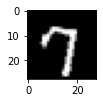

Prediction number: 3 ,right class 3


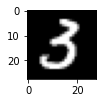

Prediction number: 4 ,right class 4


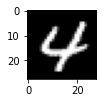

Prediction number: 2 ,right class 2


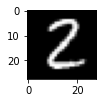

Prediction number: 6 ,right class 6


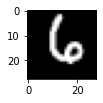

In [ ]:
  predicted_labels = classification_model.predict(test_data)
  num_images_to_show = 10
for im_ind in range(num_images_to_show):
    
    plot_ind = im_ind*2 + 1
    
    rand_ind = np.random.randint(low=0, high=test_data.shape[0])
    # rand_ind = np.random.randint(low=0, high=X_test.shape[0])
    
    fig = plt.figure(figsize=((10,15)))
    plt.subplot(num_images_to_show, 2, plot_ind)
    plt.imshow(test_data[rand_ind, :, :], cmap="gray")
    result = np.where(predicted_labels[rand_ind] == np.amax(predicted_labels[rand_ind]))
    print("Prediction number:",result[0][0],",right class",test_labels[rand_ind])
    plt.show();
    # print(predicted_labels[rand_ind])

In [ ]:
opt= keras.optimizers.Adam(learning_rate=lrate_2)
classification_model.compile(optimizer=opt,loss='categorical_crossentropy',metrics=[tf.keras.metrics.CategoricalAccuracy(),tf.keras.metrics.Recall(),tf.keras.metrics.Precision()])
for layer_freeze in classification_model.layers[:-3]:
  layer_freeze.trainable = True
callbackmod3=[
  keras.callbacks.EarlyStopping(patience=2),
  callbacks.ModelCheckpoint(filepath='model_classification_full.h5',save_best_only=True,monitor='val_loss',mode='min',),
  keras.callbacks.TensorBoard(log_dir="logs3",
  histogram_freq=1,
  write_graph=True,
  write_images=True,
  update_freq="epoch",
  profile_batch=2,
  embeddings_freq=0,
  embeddings_metadata=None)
]
  
history3 = classification_model.fit(train_data,onehot_train_labels,
                epochs=Epochs_Num,
                batch_size=batch_sz,
                validation_data=(test_data,onehot_test_labels),callbacks=[callbackmod3])


Epoch 1/100
469/469 [==============================] - 13s 28ms/step - loss: 0.0079 - categorical_accuracy: 0.9980 - recall_7: 0.9980 - precision_12: 0.9980 - val_loss: 0.0272 - val_categorical_accuracy: 0.9946 - val_recall_7: 0.9946 - val_precision_12: 0.9948
Epoch 2/100
469/469 [==============================] - 12s 26ms/step - loss: 0.0031 - categorical_accuracy: 0.9991 - recall_7: 0.9991 - precision_12: 0.9992 - val_loss: 0.0270 - val_categorical_accuracy: 0.9946 - val_recall_7: 0.9945 - val_precision_12: 0.9947
Epoch 3/100
469/469 [==============================] - 13s 27ms/step - loss: 0.0016 - categorical_accuracy: 0.9995 - recall_7: 0.9995 - precision_12: 0.9995 - val_loss: 0.0258 - val_categorical_accuracy: 0.9951 - val_recall_7: 0.9950 - val_precision_12: 0.9952
Epoch 4/100
469/469 [==============================] - 13s 27ms/step - loss: 9.3156e-04 - categorical_accuracy: 0.9998 - recall_7: 0.9998 - precision_12: 0.9998 - val_loss: 0.0253 - val_categorical_accuracy: 0.9951 - 

Prediction number: 2 ,right class 2


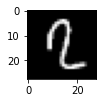

Prediction number: 6 ,right class 6


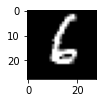

Prediction number: 0 ,right class 0


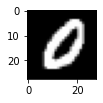

Prediction number: 4 ,right class 4


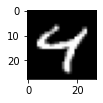

Prediction number: 2 ,right class 2


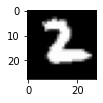

Prediction number: 0 ,right class 0


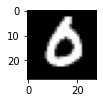

Prediction number: 8 ,right class 8


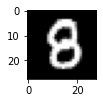

Prediction number: 7 ,right class 7


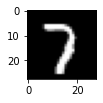

Prediction number: 0 ,right class 0


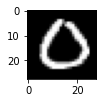

Prediction number: 4 ,right class 4


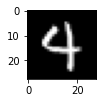

In [ ]:
  predicted_labels_2 = classification_model.predict(test_data)
  num_images_to_show = 10
  
for im_ind in range(num_images_to_show):
    
    plot_ind = im_ind*2 + 1
    
    rand_ind = np.random.randint(low=0, high=test_data.shape[0])
    
    fig = plt.figure(figsize=((10,15)))
    plt.subplot(num_images_to_show, 2, plot_ind)
    plt.imshow(test_data[rand_ind, :, :], cmap="gray")
    result = np.where(predicted_labels_2[rand_ind] == np.amax(predicted_labels_2[rand_ind]))
    print("Prediction number:",result[0][0],",right class",test_labels[rand_ind])
    plt.show();
    # print(predicted_labels[rand_ind])

0.024629993364214897


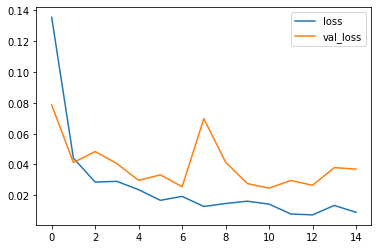

0.02507619559764862


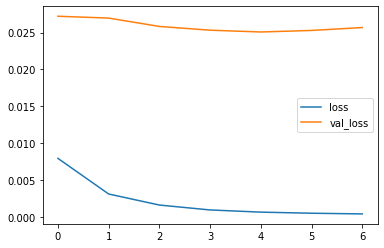

Frozen weights
Max training accuracy 0.9978166818618774
Max validation accuracy 0.9930999875068665


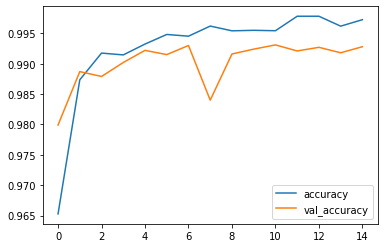

Unfrozen weights
Max training accuracy 0.9999666810035706
Max validation accuracy 0.995199978351593


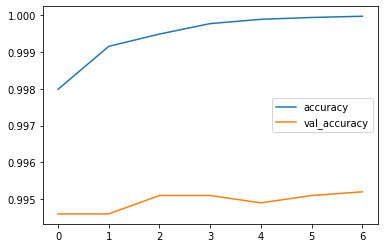

In [ ]:
loss = history2.history['loss']
val_loss = history2.history['val_loss']
print(min(val_loss))
plt.plot(loss)
plt.plot(val_loss)
plt.legend(['loss', 'val_loss'])
plt.show()

loss = history3.history['loss']
val_loss = history3.history['val_loss']
print(min(val_loss))
plt.plot(loss)
plt.plot(val_loss)
plt.legend(['loss', 'val_loss'])
plt.show()

accuracy = history2.history['categorical_accuracy']
# accuracy2 = history3.history['sparse_top_k_categorical_accuracy']
val_accuracy = history2.history['val_categorical_accuracy']
# val_accuracy2 = history3.history['val_sparse_top_k_categorical_accuracy']
print("Frozen weights")
print("Max training accuracy",max(accuracy))
print("Max validation accuracy",max(val_accuracy))
plt.plot(accuracy)
plt.plot(val_accuracy)
# plt.plot(accuracy2)
# plt.plot(val_accuracy2)
plt.legend(['accuracy', 'val_accuracy'])
plt.show()

accuracy = history3.history['categorical_accuracy']
val_accuracy = history3.history['val_categorical_accuracy']
print("Unfrozen weights")
print("Max training accuracy",max(accuracy))
print("Max validation accuracy",max(val_accuracy))
plt.plot(accuracy)
plt.plot(val_accuracy)
plt.legend(['accuracy', 'val_accuracy'])
plt.show()

In [ ]:
!ls
!mv "/content/logs2" "/content/drive/My Drive/"
!mv "/content/logs3" "/content/drive/My Drive/"
!cp "/content/model2_classification.h5" "/content/drive/My Drive/"
!cp "/content/model_classification_full.h5" "/content/drive/My Drive/"
!ls

drive  logs3			 model_classification_full.h5
logs2  model2_classification.h5  sample_data
drive  model2_classification.h5  model_classification_full.h5  sample_data
